The below code is from Scikit-Learn's example code: https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

Only a few minor changes have been made to generate model files.

In [2]:
from time import time
import logging
import matplotlib.pyplot as plt
import pickle as pk
import json

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

Load data from the LFW People dataset.  We only select classes where more than 70 images are available.

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=200, resize=0.4)
n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print(h, w)

print(X.shape)

Total dataset size:
n_samples: 766
n_features: 1850
n_classes: 2
50 37
(766, 1850)


Split the data into training and test datasets.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

Run PCA to extract the top 150 principal components distinguishing faces.  Save the PCA transformer.

In [5]:
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))
pk.dump(pca, open("pca.pkl","wb"))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 574 faces
done in 0.078s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.010s


Fit an SVM classifier onto the PCA features using grid search for hyperparameter tuning.  Save the best classifier model.

In [6]:
print("Fitting the SVM classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
pk.dump(clf, open("svm.pkl","wb"))

print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the SVM classifier to the training set
done in 5.810s
Best estimator found by grid search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.005,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


Fit a Random Forest classifier.

In [6]:
"""
print("Fitting the RF classifier to the training set")
t0 = time()
param_grid = {'max_depth': [5, 10, 20],
              'min_samples_split': [5, 10, 20, 30],
              'min_samples_leaf': [1, 5, 10, 20], }
clf = GridSearchCV(
    RandomForestClassifier(n_estimators=50, criterion='gini', max_features='sqrt', class_weight='balanced'), 
    param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)
"""

'\nprint("Fitting the RF classifier to the training set")\nt0 = time()\nparam_grid = {\'max_depth\': [5, 10, 20],\n              \'min_samples_split\': [5, 10, 20, 30],\n              \'min_samples_leaf\': [1, 5, 10, 20], }\nclf = GridSearchCV(\n    RandomForestClassifier(n_estimators=50, criterion=\'gini\', max_features=\'sqrt\', class_weight=\'balanced\'), \n    param_grid\n)\nclf = clf.fit(X_train_pca, y_train)\nprint("done in %0.3fs" % (time() - t0))\nprint("Best estimator found by grid search:")\nprint(clf.best_estimator_)\n'

Predict on the test set to generate confusion matrix.

In [7]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(y_pred)

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.021s
[1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0
 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0 1 1
 1 0 1 1 0 0 1]
               precision    recall  f1-score   support

 Colin Powell       0.98      0.90      0.94        59
George W Bush       0.96      0.99      0.97       133

     accuracy                           0.96       192
    macro avg       0.97      0.95      0.96       192
 weighted avg       0.96      0.96      0.96       192

[[ 53   6]
 [  1 132]]


Plot the principal components.

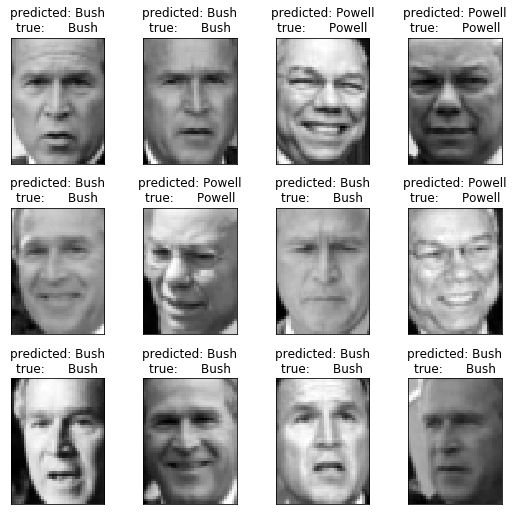

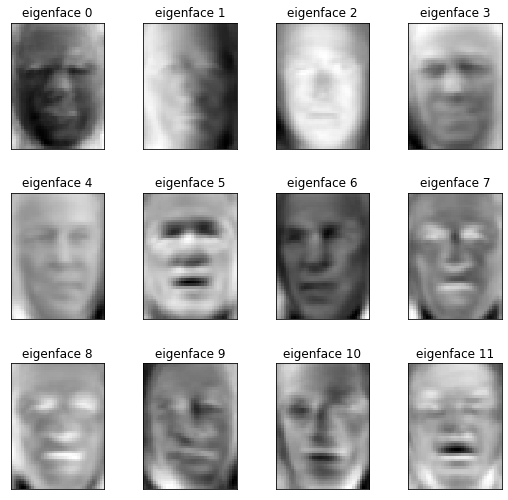

In [8]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

target_dict = {}
for i, target in enumerate(target_names):
    target_dict[i] = target
with open('target_names.json', 'w') as outfile:
    json.dump(target_dict, outfile)
    
        
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()